In [1]:
import re
import pandas as pd
import numpy as np
from glob import glob
import networkx as nx
import time
import matplotlib.pyplot as plt
# from functools import reduce
import os
from itertools import combinations

# !conda install -c conda-forge tqdm -y
from tqdm import tqdm
# !pip install multiprocess
from multiprocess import Pool

In [2]:
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

In [13]:
!ls /Volumes/Lexar/HinDroid/data/interim

class0 class1


In [17]:
glob('/Volumes/Lexar/HinDroid/data/interim/class0/*.csv')

['/Volumes/Lexar/HinDroid/data/interim/class0/smscommand.main.csv',
 '/Volumes/Lexar/HinDroid/data/interim/class0/com.IndoApps.PetaPintar.csv',
 '/Volumes/Lexar/HinDroid/data/interim/class0/emojikeyboard.emoji.gif.keyboard.facebookmessenger.theme.neonlights.csv',
 '/Volumes/Lexar/HinDroid/data/interim/class0/com.superboost.app.cleaner.junkclean.csv',
 '/Volumes/Lexar/HinDroid/data/interim/class0/new.tips.tekken7.csv',
 '/Volumes/Lexar/HinDroid/data/interim/class0/de.marcelknupfer.studentenausweisguthaben.csv',
 '/Volumes/Lexar/HinDroid/data/interim/class0/antfacto.musgan.com.removeentertext.csv',
 '/Volumes/Lexar/HinDroid/data/interim/class0/com.diversepower.smartapps.csv',
 '/Volumes/Lexar/HinDroid/data/interim/class0/com.protoolapps.androidupgrade.csv',
 '/Volumes/Lexar/HinDroid/data/interim/class0/com.inhancetechnology.amtrust.csv']

In [4]:
interim_classes_dirs = {
    'class0': glob('/Volumes/Lexar/HinDroid/data/interim/class0/*.csv')[:8],
    'class1': glob('/Volumes/Lexar/HinDroid/data/interim/class1/*.csv')[:8],
}

In [5]:
def aggregate_raw(interim_classes_dirs):
    labels = {}
    df = pd.DataFrame()
    for class_i, csv_ls in interim_classes_dirs.items():
        app_dfs = []

        print(f'Reading csv files for {class_i}')
        time.sleep(1)
        for csv in tqdm(csv_ls):
            app_df = pd.read_csv(
                csv, dtype={'method_name': str},
                keep_default_na=False
            )
            app_package = os.path.basename(csv)[:-4]
            labels[app_package] = class_i
            app_df['package'] = app_package
            app_dfs.append(app_df)

        class_i_df = pd.concat(app_dfs, ignore_index=True)
        class_i_df['class'] = class_i
        df = df.append(class_i_df, ignore_index=True)

    return df, pd.Series(labels)

In [6]:
df, labels = aggregate_raw(interim_classes_dirs)

Reading csv files for class0


100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Reading csv files for class1


100%|██████████| 8/8 [00:01<00:00,  6.16it/s]


In [7]:
df['api'] = df.library + '->' + df.method_name

In [8]:
df['api_id'] = df.groupby('api').ngroup()

In [9]:
df.api_id.max()

120455

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059741 entries, 0 to 1059740
Data columns (total 10 columns):
call             1059741 non-null object
relpath          1059741 non-null object
code_block_id    1059741 non-null int64
invocation       1059741 non-null object
library          1059741 non-null object
method_name      1059741 non-null object
package          1059741 non-null object
class            1059741 non-null object
api              1059741 non-null object
api_id           1059741 non-null int64
dtypes: int64(2), object(8)
memory usage: 80.9+ MB


In [11]:
api_id_lookup = df[['api', 'api_id']].set_index('api')['api_id'].to_dict()

In [12]:
unique_APIs_app = df.groupby('package').apply(
    lambda f: set(f.api_id)
).to_dict()

unique_APIs_all = set.union(*unique_APIs_app.values())

A_cols = []
for unique in unique_APIs_all:
    bag_of_API = [True if unique in app_set else False for app_set in unique_APIs_app.values()]
    A_cols.append(bag_of_API)

A_mat = np.array(A_cols, dtype='i1').T

In [13]:
A_mat.shape

(16, 120456)

In [14]:
A_mat.size * A_mat.itemsize

1927296

In [16]:
A_mat.tofile('test')

In [26]:
tqdm.pandas()

/Users/user/anaconda3/envs/dsc180/lib/python3.8/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [27]:
g = df.groupby(['package', 'code_block_id']).progress_apply(
    lambda f: list(combinations(f.api_id, 2))
)

100%|██████████| 241876/241876 [00:16<00:00, 15095.60it/s]


In [68]:
l = g.explode().drop_duplicates().dropna().apply(lambda x:list(x)).to_numpy()

In [32]:
B_mat = lil_matrix((df.api_id.nunique(), df.api_id.nunique()), dtype='i1')

In [38]:
B_mat.shape

(120456, 120456)

In [70]:
len(l)

1591925

In [40]:
from scipy.sparse import csr_matrix, lil_matrix, coo_matrix

In [ ]:
B_mat = csr_matrix(B_mat)

In [ ]:
np.dot(A_mat, B_mat).dot(A_mat.T)

In [41]:
row  = np.array([0, 0, 1, 3, 1, 0, 0])
col  = np.array([0, 2, 1, 3, 1, 0, 0])
data = np.array([1, 1, 1, 1, 1, 1, 1])
coo = coo_matrix((data, (row, col)), shape=(4, 4))

In [47]:
coo.dot(coo.T).toarray()

array([[10,  0,  0,  0],
       [ 0,  4,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  1]], dtype=int64)

## EDA

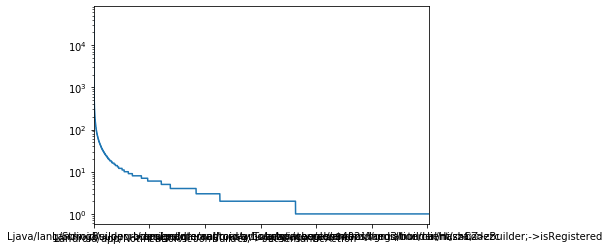

In [93]:
df['api'].value_counts().plot(logy=True)

In [120]:
df['api'].nunique()

120456

In [94]:
(df['api'].value_counts() >= 1).sum() / df['api'].nunique()

1.0

In [95]:
(df['api'].value_counts() >= 2).sum() / df['api'].nunique()

0.6024772531048682

In [96]:
(df['api'].value_counts() >= 3).sum() / df['api'].nunique()

0.3765358305107259

In [97]:
(df['api'].value_counts() >= 5).sum() / df['api'].nunique()

0.2284983728498373

In [98]:
(df['api'].value_counts() >= 10).sum() / df['api'].nunique()

0.1030749817360696

In [119]:
df.groupby('package')['api'].apply(lambda s: pd.Series(s.unique())).value_counts()

Ljava/util/ArrayList;->iterator                                          16
Landroid/net/Uri;->parse                                                 16
Ljava/lang/String;->substring                                            16
Ljava/lang/String;->contains                                             16
Landroid/content/Context;->getApplicationContext                         16
                                                                         ..
Lcom/google/android/gms/internal/zznt;->onRewardedVideoAdFailedToLoad     1
Lcom/google/android/gms/internal/ads/zzabp;->zzn                          1
Landroid/support/transition/TransitionManagerStaticsImpl;->go             1
Lkotlin/coroutines/jvm/internal/DebugMetadataKt;->getLabel                1
Landroid/support/v4/provider/FontRequest;->getProviderPackage             1
Name: api, Length: 120456, dtype: int64

In [6]:
hin = SmaliHIN(APPS_DIR)

100%|██████████| 8/8 [01:53<00:00, 14.25s/it]


In [7]:
apps = [a for a in hin.apps.values()]

In [8]:
for a in apps:
    a.info['package'] = a.package

In [9]:
df = pd.concat([a.info for a in apps], ignore_index=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176529 entries, 0 to 1176528
Data columns (total 7 columns):
call             1176529 non-null object
relpath          1176529 non-null object
code_block_id    1176529 non-null int64
invocation       1176529 non-null object
library          1176529 non-null object
method_name      1176529 non-null object
package          1176529 non-null object
dtypes: int64(1), object(6)
memory usage: 62.8+ MB


In [56]:
df.head(5)

,call,relpath,code_block_id,invocation,library,method_name,package,class
0,"invoke-direct {p0}, Landroid/support/v4/access...",smali/android/support/v4/accessibilityservice/...,3,invoke-direct,Landroid/support/v4/accessibilityservice/Acces...,<init>,smscommand.main,class0
1,"invoke-static {p1}, Landroid/support/v4/access...",smali/android/support/v4/accessibilityservice/...,4,invoke-static,Landroid/support/v4/accessibilityservice/Acces...,getCanRetrieveWindowContent,smscommand.main,class0
2,"invoke-static {p1}, Landroid/support/v4/access...",smali/android/support/v4/accessibilityservice/...,5,invoke-static,Landroid/support/v4/accessibilityservice/Acces...,getDescription,smscommand.main,class0
3,"invoke-static {p1}, Landroid/support/v4/access...",smali/android/support/v4/accessibilityservice/...,6,invoke-static,Landroid/support/v4/accessibilityservice/Acces...,getId,smscommand.main,class0
4,"invoke-static {p1}, Landroid/support/v4/access...",smali/android/support/v4/accessibilityservice/...,7,invoke-static,Landroid/support/v4/accessibilityservice/Acces...,getResolveInfo,smscommand.main,class0


In [57]:
df.groupby('package')['invocation'].value_counts().unstack(fill_value=0)

invocation,invoke-direct,invoke-interface,invoke-static,invoke-super,invoke-virtual
package,,,,,
antfacto.musgan.com.removeentertext,25388,11784,26698,2112,70654
com.IndoApps.PetaPintar,995,317,902,39,2778
com.app.p5982DI,14123,5370,13584,658,34897
com.colombitrade.presto,21520,12760,25110,964,59500
com.comunicanos.app,4510,1692,3680,232,12622
com.diversepower.smartapps,15365,5135,15402,2020,81211
com.gamerun.moma,24982,13720,32880,1356,76226
com.grupy.grupy,28491,15812,32733,1491,78650
com.inhancetechnology.amtrust,51519,21266,34637,1659,116299


In [33]:
df.groupby('package').agg({
    'call': 'size',
    'library': 'nunique',
    'code_block_id': ['mean', 'std', 'median', 'max', 'nunique'],
})

call code_block_id  \
                                                     size          mean   
package                                                                   
com.app.brboldiesradio                             314469  44924.059815   
com.ct.goatsimulator3d                              99605  15819.729873   
com.gallusgolf.c625.android.hawkseyegolf            66259  12261.962239   
com.mobiledoorman.themercer                        123376  18288.249481   
com.vistekmedia.ForestSmashFrenzy                   59430  11349.214471   
grossacapdany.ovilsolutions.com.lagrossadecapdany  230268  36520.605651   
my.name.kiss.name                                   25529   3000.147754   
uk.co.prioritysms.bgcracing                        257593  40520.654633   

                                                                               \
                                                            std median    max   
package                                                                         
com.app.brboldiesradio                             26047.871290  43838  89872   
com.ct.goatsimulator3d                              8635.689824  16084  30656   
com.gallusgolf.c625.android.hawkseyegolf            6181.687412  12927  21532   
com.mobiledoorman.themercer                        10398.392019  18923  35745   
com.vistekmedia.ForestSmashFrenzy                   5888.003081  12248  20166   
grossacapdany.ovilsolutions.com.lagrossadecapdany  18864.652112  38391  68122   
my.name.kiss.name                                   1885.667432   2858   6590   
uk.co.prioritysms.bgcracing                        23689.291276  39385  79603   

                                                          library  
                                                  nunique nunique  
package                                                            
com.app.brboldiesradio                              67457   13184  
com.ct.goatsimulator3d                              21115    4684  
com.gallusgolf.c625.android.hawkseyegolf            15922    3539  
com.mobiledoorman.themercer                         27661    6490  
com.vistekmedia.ForestSmashFrenzy                   14964    3721  
grossacapdany.ovilsolutions.com.lagrossadecapdany   50638   10622  
my.name.kiss.name                                    4852    1613  
uk.co.prioritysms.bgcracing                         59276   10875

## graphs 

In [10]:
A_mat = hin.construct_graph_A()

In [11]:
A_mat.shape

(4, 58646)

In [27]:
pd.Series(A_mat.sum(axis=0)).value_counts().sort_index()

1    123087
2     27408
3      6173
4      6505
5      3079
6      1243
7      2942
8      2410
dtype: int64

In [18]:
A_mat.shape

(8, 172847)

In [9]:
def method_pairs(df_group, graph):
    calls = df_group.api_id.unique()
    pairs = combinations(calls, 2)
    for pair in pairs:
        graph.add_edge(*pair)

In [10]:
%%time
B = nx.Graph()
B.add_nodes_from(df.api_id.unique())

B_pairs = df.groupby('code_block_id').progress_apply(method_pairs, graph=B)

100%|██████████| 25112/25112 [00:04<00:00, 5340.10it/s]

CPU times: user 4.67 s, sys: 108 ms, total: 4.78 s
Wall time: 4.73 s


In [11]:
%%time
P = nx.Graph()
P.add_nodes_from(df.api_id.unique())

P_pairs = df.groupby('package').progress_apply(method_pairs, graph=P)

100%|██████████| 5250/5250 [00:01<00:00, 3793.50it/s]

CPU times: user 1.39 s, sys: 52 ms, total: 1.44 s
Wall time: 1.43 s


In [33]:
df[['invocation', 'api_id']]

,invocation,api_id
0,invoke-direct,22062
1,invoke-direct,22062
2,invoke-direct,22062
3,invoke-direct,22062
4,invoke-direct,22062
...,...,...
103884,invoke-virtual,24772
103885,invoke-virtual,1619
103886,invoke-interface,495
103887,invoke-super,1616


In [12]:
# nx.drawing.draw(B)

In [13]:
df.groupby('invocation').apply(lambda df:len(df)**2/2).sum()

1888812409.5

In [14]:
df.call.nunique()**2/2

1088624460.5

In [15]:
%%time
I = nx.Graph()
I.add_nodes_from(df.call.unique())

# I_pairs = df.groupby('invocation').progress_apply(method_pairs, graph=I)

CPU times: user 83.2 ms, sys: 8.52 ms, total: 91.7 ms
Wall time: 89.6 ms


In [16]:
df.invocation.value_counts()

invoke-virtual      53840
invoke-static       20273
invoke-direct       19725
invoke-interface     8787
invoke-super         1264
Name: invocation, dtype: int64

In [17]:
# df_group = df.loc[df.groupby('invocation').groups['invoke-virtual'], :]
# # print(df_group.shape)
# calls = df_group.api_id.unique()
# pairs = combinations(calls, 2)
# for pair in tqdm(pairs, total=len(calls)*(len(calls)-1)/2):
#     I.add_edge(pair[0], pair[1])

#     del pair
#     break

In [18]:
df.sort_values('api_id').head()

,call,filename,code_block_id,invocation,package,method_name,api_id
4234,"invoke-virtual {p0}, Landroid/accessibilityser...",./../data/apps/com.paro.xmastreehdwallpaper/xm...,1407,invoke-virtual,Landroid/accessibilityservice/AccessibilitySer...,getCanRetrieveWindowContent,0
4240,"invoke-virtual {p0}, Landroid/accessibilityser...",./../data/apps/com.paro.xmastreehdwallpaper/xm...,1413,invoke-virtual,Landroid/accessibilityservice/AccessibilitySer...,getCapabilities,1
4235,"invoke-virtual {p0}, Landroid/accessibilityser...",./../data/apps/com.paro.xmastreehdwallpaper/xm...,1408,invoke-virtual,Landroid/accessibilityservice/AccessibilitySer...,getDescription,2
4236,"invoke-virtual {p0}, Landroid/accessibilityser...",./../data/apps/com.paro.xmastreehdwallpaper/xm...,1409,invoke-virtual,Landroid/accessibilityservice/AccessibilitySer...,getId,3
4237,"invoke-virtual {p0}, Landroid/accessibilityser...",./../data/apps/com.paro.xmastreehdwallpaper/xm...,1410,invoke-virtual,Landroid/accessibilityservice/AccessibilitySer...,getResolveInfo,4


In [72]:
n = df.api_id.nunique()
A = np.zeros((n,n))

from scipy.sparse import csr_matrix
# A = csr_matrix((n, n))

In [73]:
df_group = df.loc[df.groupby('invocation').groups['invoke-virtual'], :]
# print(df_group.shape)
calls = df_group.api_id.unique()
pairs = combinations(calls, 2)
for pair in tqdm(pairs, total=len(calls)*(len(calls)-1)/2):
    A[pair[0], pair[1]] = 1
    A[pair[1], pair[0]] = 1

  3%|▎         | 46890717/1733338881.0 [00:58<47:20, 593774.96it/s]  

KeyboardInterrupt: 

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [25]:
from scipy.sparse import csr_matrix

In [26]:
a = csr_matrix(A)

In [29]:
sys.getsizeof(a)

48

In [24]:
import sys
sys.getsizeof(A)/1e9

4.933025904